In [27]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [13]:
! pip install --upgrade pip setuptools wheel
! pip install pandas 
! pip install numpy tensorflow
! pip install split-folders
!pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [56]:
# Splitting Dataset
import splitfolders
input_dir = "/content/drive/MyDrive/dataset"
output_dir = "/content/drive/MyDrive/SplittedDataset"

splitfolders.ratio(input_dir, output_dir, seed=1337, ratio=(.8,.2), group_prefix=None)


Copying files: 315 files [00:03, 91.49 files/s]


In [57]:
train_dir = "/content/drive/MyDrive/SplittedDataset/train"
valid_dir = "/content/drive/MyDrive/SplittedDataset/val"
img_width, img_height = 224, 224  # Default input size for VGG16

# Instantiate convolutional base
model_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

# Show architecture
model_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [59]:
# Extract features
!pip install Pillow

import os, shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count,6))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='categorical')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = model_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
#         print(batch_size, sample_count)
    return features, labels
    
train_features, train_labels = extract_features(train_dir, 251)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(valid_dir, 64)

Found 251 images belonging to 6 classes.
Found 127 images belonging to 6 classes.


In [60]:
train_labels


array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [61]:
train_features


array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 5.78598917e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 4.98155057e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 4.01957154e-01, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 2.91293353e-01, ...,
          0.00000000e+00, 5.11038244e-01, 0.00000000e+00],
         [0.00000000e+00, 3.63127410e-01, 7.88359523e-01, ...,
          0.00000000e+00, 3.38272899e-01, 0.00000000e+00],
         [3.18141997e-01, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 3.08210582e-01, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 7.51035452e-01, ...,
          0.00000000e+00, 4.89432424e-01, 0.00000000e+00],
         [0.00000000e+00, 1.53726995e-01, 2.42462683e+00, ...,
          2.91336402e-02, 6.45512342e-01, 0.00000000e+00],
        

In [62]:
validation_labels


array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0.

In [63]:
epochs = 150

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=(7,7,512)))
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 3,078
Trainable params: 3,078
Non-trainable params: 0
_________________________________________________________________


In [64]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

# Compile model
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['acc'])

# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    callbacks=[checkpoint],
                    validation_data=(validation_features, validation_labels))

Epoch 1/150
1/8 [==>...........................] - ETA: 2s - loss: 2.0840 - acc: 0.0938
Epoch 00001: val_loss improved from inf to 1.80975, saving model to model-001-0.135458-0.296875.h5
8/8 [==============================] - 1s 30ms/step - loss: 1.9554 - acc: 0.1355 - val_loss: 1.8098 - val_acc: 0.2969
Epoch 2/150
1/8 [==>...........................] - ETA: 0s - loss: 1.8324 - acc: 0.1562
Epoch 00002: val_loss improved from 1.80975 to 1.73841, saving model to model-002-0.254980-0.296875.h5
8/8 [==============================] - 0s 8ms/step - loss: 1.7740 - acc: 0.2550 - val_loss: 1.7384 - val_acc: 0.2969
Epoch 3/150
1/8 [==>...........................] - ETA: 0s - loss: 1.7408 - acc: 0.2188
Epoch 00003: val_loss improved from 1.73841 to 1.69082, saving model to model-003-0.286853-0.312500.h5
8/8 [==============================] - 0s 9ms/step - loss: 1.7035 - acc: 0.2869 - val_loss: 1.6908 - val_acc: 0.3125
Epoch 4/150
1/8 [==>...........................] - ETA: 0s - loss: 1.6111 - acc

In [65]:
from keras.preprocessing import image
def prediction(img_path):
    org_img = image.load_img(img_path)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(org_img)                           
    plt.axis('off')
    plt.show()


    # Extract features
    features = model_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

    # Make prediction
    try:
        prediction = model.predict(features)
    except:
        prediction = model.predict(features.reshape(1, 7*7*512))
        
    classes = ["ant", "budhha", "dolphin", "elephant", "flamingo", "rooster"]
    print("This Image is of a... "+str(classes[np.argmax(np.array(prediction[0]))]))

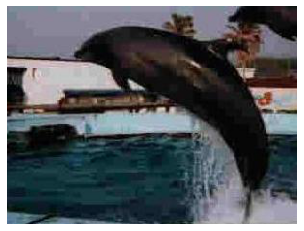

This Image is of a... dolphin


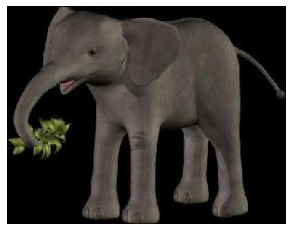

This Image is of a... elephant


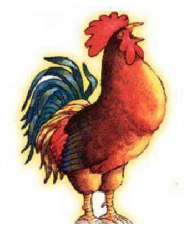

This Image is of a... rooster


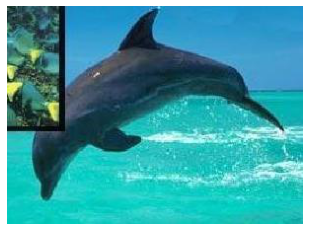

This Image is of a... dolphin


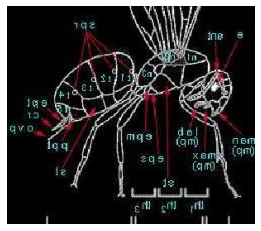

This Image is of a... ant


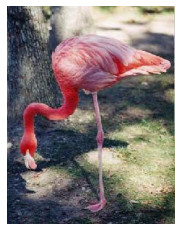

This Image is of a... flamingo


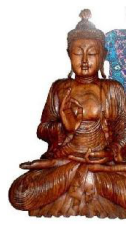

This Image is of a... budhha


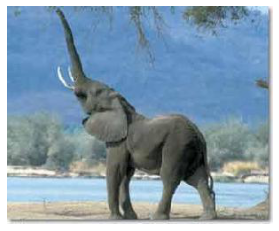

This Image is of a... elephant


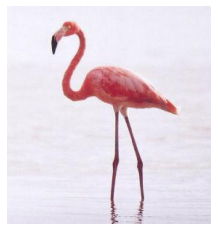

This Image is of a... flamingo


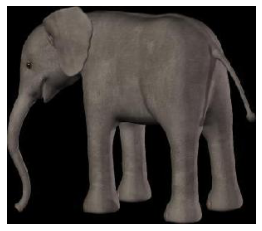

This Image is of a... elephant


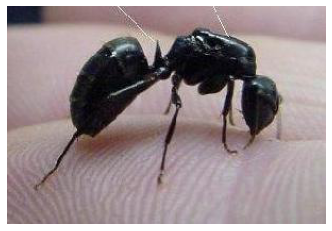

This Image is of a... ant


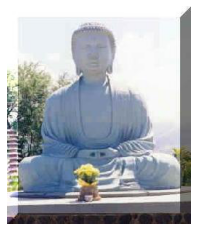

This Image is of a... budhha


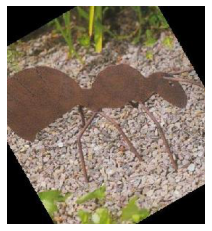

This Image is of a... ant


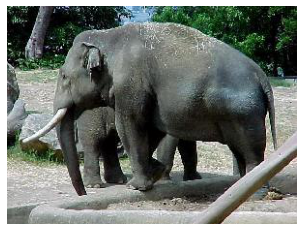

This Image is of a... elephant


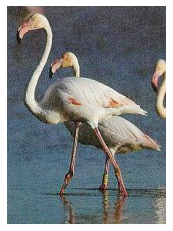

This Image is of a... flamingo


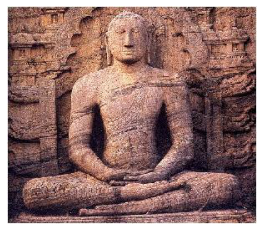

This Image is of a... budhha


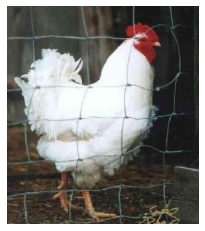

This Image is of a... elephant


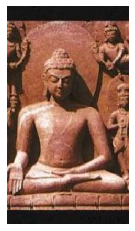

This Image is of a... budhha


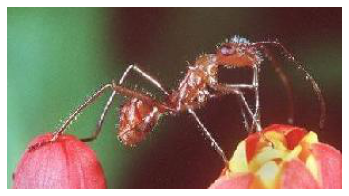

This Image is of a... ant


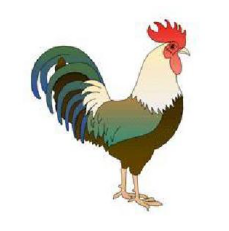

This Image is of a... rooster


In [66]:
import random
import matplotlib.pyplot as plt

pred_dir = []
for d in os.listdir("/content/drive/MyDrive/dataset/"):
    for f in os.listdir("/content/drive/MyDrive/dataset/"+str(d)):
        pred_dir.append(str(d)+"/"+f)
pred_files = random.sample(pred_dir,20)
for f in pred_files:
    prediction("/content/drive/MyDrive/dataset/"+f)

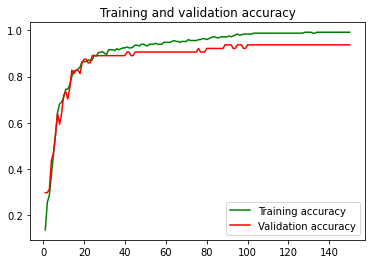

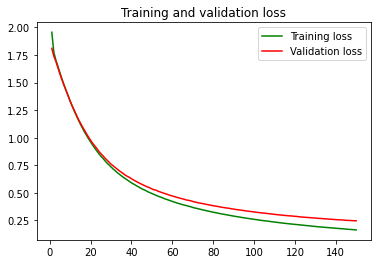

In [68]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [83]:
error_rate = (sum(acc)-sum(val_acc))
error_rate


5.354708224534988

In [84]:
print("Accuracy = ",100 - error_rate)

Accuracy =  94.64529177546501
